In [2]:
from PIL import Image, UnidentifiedImageError
import os

data_dir = r"C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\images"
removed = 0

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    for filename in os.listdir(class_path):
        fpath = os.path.join(class_path, filename)
        try:
            with Image.open(fpath) as img:
                img.verify()  # 손상 이미지 탐지
        except (UnidentifiedImageError, IOError, SyntaxError):
            os.remove(fpath)
            removed += 1
            print(f"🗑️ Removed broken image: {fpath}")

print(f"\n✅ Cleaning done. {removed} corrupted images deleted.")

🗑️ Removed broken image: C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\images\brushing_teeth\person_brushing_teeth_5.jpg
🗑️ Removed broken image: C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\images\drinking\person_drinking_water_5.jpg
🗑️ Removed broken image: C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\images\eating\person_eating_food_4.jpg
🗑️ Removed broken image: C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\images\reading\person_reading_book_6.jpg
🗑️ Removed broken image: C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\images\sleeping\person_sleeping_in_bed_5.jpg
🗑️ Removed broken image: C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\images\typing\person_typing_on_laptop_5.jpg
🗑️ Removed broken image: C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\images\walking\person_walking_outside_1.jpg
🗑️ Removed broken image: C:\

Found 3001 images belonging to 8 classes.
Found 743 images belonging to 8 classes.
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.1857 - loss: 2.4853 - val_accuracy: 0.4630 - val_loss: 1.4968 - learning_rate: 0.0010
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.3683 - loss: 1.8269 - val_accuracy: 0.5182 - val_loss: 1.3401 - learning_rate: 0.0010
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.4554 - loss: 1.5496 - val_accuracy: 0.5114 - val_loss: 1.3153 - learning_rate: 0.0010
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.4753 - loss: 1.4770 - val_accuracy: 0.5424 - val_loss: 1.2786 - learning_rate: 0.0010
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.4963 - loss: 1.3956 - val_accuracy: 0.5370 - val_loss: 1.2606 - learning_rate: 0.0010
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.5009 - loss: 1.3994 - val_accuracy: 0.5249 - val_loss: 1.2441 - learning_rate: 0.0010
Epoch 7/10


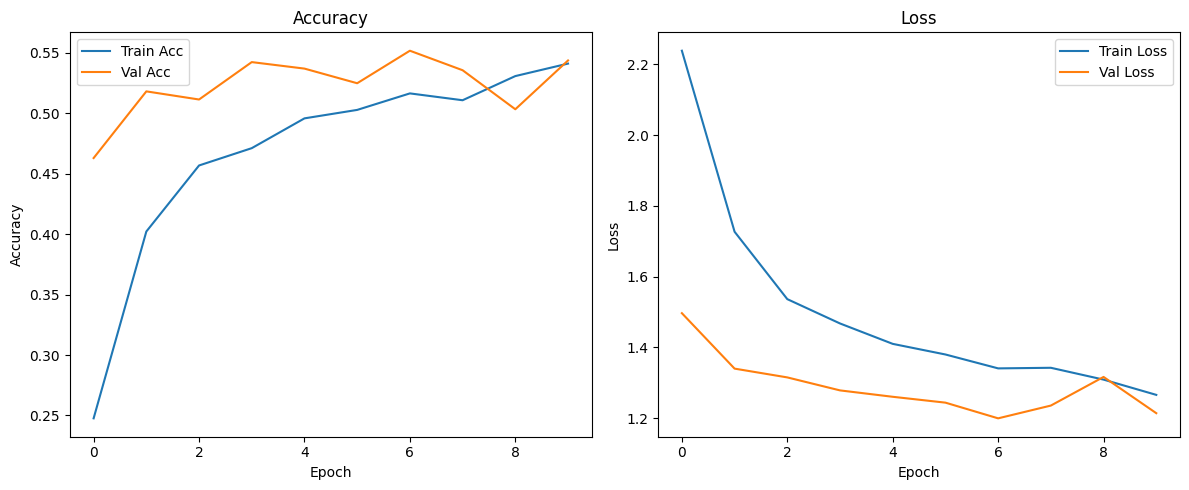

In [7]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 🧱 하이퍼파라미터
IMG_SIZE = 224  # MobileNetV2 입력 사이즈
BATCH_SIZE = 32
EPOCHS = 10

# 📂 데이터 경로
data_dir = r"C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\images"

# 📈 데이터 증강 + 자동 분할
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# 🧠 전이학습 모델 구성
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # backbone freeze

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # 기본 0.5 적용
outputs = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# ⚙️ 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# 🚀 훈련
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[lr_scheduler]
)

# 🏆 최고 성능 출력
best_epoch = max(enumerate(history.history['val_accuracy']), key=lambda x: x[1])
print(f"\n🏆 Best Val Acc: {best_epoch[1]:.4f} at Epoch {best_epoch[0] + 1}")

# 📊 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()